Step 1: Loading Data...
Classes: ["Alzheimer's Disease" 'Frontotemporal Dementia' 'Lewy Body Dementia'
 "Parkinson's Disease" 'Vascular Dementia']
Step 2: Extracting N-gram Features...
Feature Matrix Shape: (800, 5000)

Step 3: Training Random Forest...
Running 10-Fold Cross-Validation...
Mean CV Accuracy: 0.5425
Standard Deviation: 0.0380

Step 4: Plotting Learning Curves...


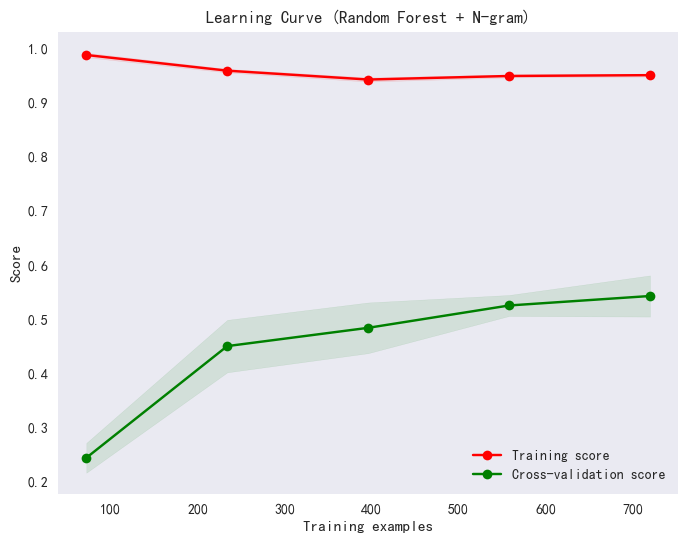


--- Classification Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.55      0.72      0.62        40
Frontotemporal Dementia       0.62      0.65      0.63        40
     Lewy Body Dementia       0.66      0.53      0.58        40
    Parkinson's Disease       0.64      0.57      0.61        40
      Vascular Dementia       0.68      0.62      0.65        40

               accuracy                           0.62       200
              macro avg       0.63      0.62      0.62       200
           weighted avg       0.63      0.62      0.62       200



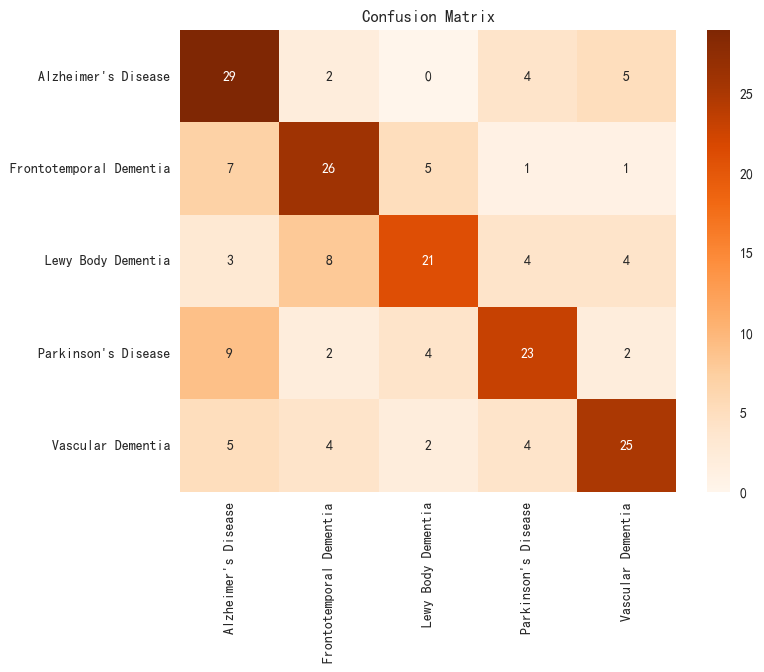

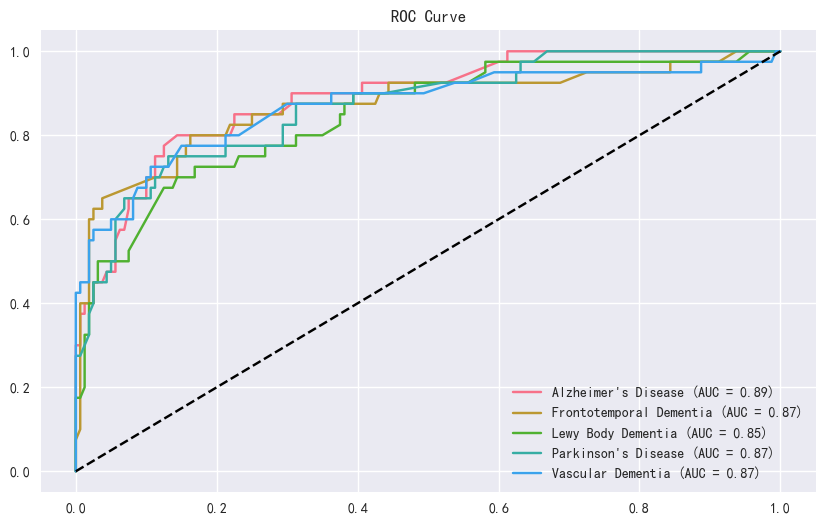


Step 6: Error Analysis...
Top Words in Errors: [('pad', np.int64(1308)), ('disease', np.int64(321)), ('patient', np.int64(49)), ('study', np.int64(37)), ('cognitive', np.int64(29)), ('brain', np.int64(28)), ('neurodegenerative', np.int64(22)), ('tau', np.int64(21)), ('year', np.int64(21)), ('clinical', np.int64(20)), ('protein', np.int64(20)), ('diagnosis', np.int64(19)), ('method', np.int64(19)), ('available', np.int64(18)), ('using', np.int64(16)), ('model', np.int64(15)), ('abstract', np.int64(13)), ('change', np.int64(13)), ('syn', np.int64(13)), ('related', np.int64(12))]
--- Failure Example ---
True: Lewy Body Dementia | Pred: Parkinson's Disease
Text: growing body evidence support use cardiac sympathetic innervation imaging risk stratify patient hear...

Step 7: SHAP Analysis (N-gram contribution)...
SHAP skipped: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import shap
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据加载与预处理 (Data Loading & Preprocessing)
# ==========================================
print("Step 1: Loading Data...")
try:
    df = pd.read_csv('../cleaned_data.csv')
except FileNotFoundError:
    df = pd.read_csv('cleaned_data.csv')

df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

# 标签编码
le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
label_names = le.classes_
print(f"Classes: {label_names}")

# 划分
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label_Encoded'], 
    test_size=0.2, random_state=42, stratify=df['Label_Encoded']
)

# ==========================================
# 2. 特征工程: N-gram (Feature Engineering)
# ==========================================
print("Step 2: Extracting N-gram Features...")
# 使用 CountVectorizer 提取 1-gram 和 2-gram 特征
# max_features 限制为 5000 (适当减小以加速 SHAP 计算)
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000, stop_words='english')

X_train_features = vectorizer.fit_transform(X_train_raw)
X_test_features = vectorizer.transform(X_test_raw)
feature_names = vectorizer.get_feature_names_out()

print(f"Feature Matrix Shape: {X_train_features.shape}")

# ==========================================
# 3. 模型训练: Random Forest
# ==========================================
print("\nStep 3: Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 3.1 10-Fold CV
print("Running 10-Fold Cross-Validation...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_features, y_train, cv=cv, scoring='accuracy')

print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Train Full Model
rf_model.fit(X_train_features, y_train)

# ==========================================
# 4. 学习曲线 (Bias vs Variance)
# ==========================================
print("\nStep 4: Plotting Learning Curves...")
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(rf_model, "Learning Curve (Random Forest + N-gram)", X_train_features, y_train, cv=cv, n_jobs=-1)

# ==========================================
# 5. 评估与可视化
# ==========================================
y_pred = rf_model.predict(X_test_features)
y_prob = rf_model.predict_proba(X_test_features)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=label_names))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.show()

# ROC
plt.figure(figsize=(10, 6))
y_test_bin = pd.get_dummies(y_test).values
if y_test_bin.shape[1] == len(label_names):
    for i, class_label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# ==========================================
# 6. 误差分析 (Error Analysis)
# ==========================================
print("\nStep 6: Error Analysis...")
misclassified_indices = np.where(y_test != y_pred)[0]
if len(misclassified_indices) > 0:
    error_docs = X_test_raw.iloc[misclassified_indices]
    error_cv = CountVectorizer(stop_words='english', max_features=20)
    try:
        error_counts = error_cv.fit_transform(error_docs)
        error_words = error_cv.get_feature_names_out()
        error_word_freq = np.asarray(error_counts.sum(axis=0)).flatten()
        print(f"Top Words in Errors: {sorted(dict(zip(error_words, error_word_freq)).items(), key=lambda x: x[1], reverse=True)}")
    except:
        pass
    
    print("--- Failure Example ---")
    if len(misclassified_indices) > 0:
        idx = misclassified_indices[0]
        print(f"True: {label_names[y_test.iloc[idx]]} | Pred: {label_names[y_pred[idx]]}")
        print(f"Text: {X_test_raw.iloc[idx][:100]}...")

# ==========================================
# 7. 可解释性 SHAP (Explainability)
# ==========================================
print("\nStep 7: SHAP Analysis (N-gram contribution)...")
try:
    # 使用 TreeExplainer
    # Approximate=True 可以加速
    explainer = shap.TreeExplainer(rf_model)
    
    sample_size = min(50, X_test_features.shape[0])
    X_shap_sample = X_test_features[:sample_size].toarray() # Convert sparse to dense for shap if needed (older versions)
    
    shap_values = explainer.shap_values(X_shap_sample)
    
    target_idx = 0
    if isinstance(shap_values, list):
        sv = shap_values[target_idx]
    else:
        sv = shap_values[:, :, target_idx]
        
    print(f"SHAP Summary for Class: {label_names[target_idx]}")
    shap.summary_plot(sv, X_shap_sample, feature_names=feature_names, show=False)
    plt.show()
except Exception as e:
    print(f"SHAP skipped: {e}")